In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
from uibcdf_test_systems.systems import DoubleWell
from uibcdf_test_systems.simulation import langevin_NVT
import simtk.unit as unit
import numpy as np
import matplotlib.pyplot as plt

In [3]:
double_well_asymmetric = DoubleWell(n_particles = 1, mass = 64 * unit.amu,
                                    Eo=4.0 * unit.kilocalories_per_mole,
                                    a=1.0 * unit.nanometers,
                                    b=0.25 * unit.kilocalories_per_mole)

In [4]:
double_well_asymmetric.coordinates_minima()

[Quantity(value=-0.992093989581487, unit=nanometer),
 Quantity(value=1.00772280707545, unit=nanometer)]

In [5]:
double_well_asymmetric.coordinates_maxima()

[Quantity(value=-0.0156288174939649, unit=nanometer)]

In [6]:
double_well_asymmetric.armonic_oscillation_periods()

([Quantity(value=-0.992093989581487, unit=nanometer),
  Quantity(value=1.00772280707545, unit=nanometer)],
 [Quantity(value=4.396332602439496, unit=picosecond),
  Quantity(value=4.2944393987875795, unit=picosecond)],
 [Quantity(value=0, unit=nanometer)],
 [Quantity(value=4.344092140155338, unit=picosecond)])

In [15]:
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_positions[0,0] = 1.0 * unit.nanometers

initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

time, traj, _, _, _ = langevin_NVT (double_well_asymmetric,
                                    temperature = 300 * unit.kelvin,
                                    friction = 5.0/unit.picoseconds,
                                    initial_positions = initial_positions,
                                    initial_velocities = initial_velocities,
                                    integration_timestep = 0.2 * unit.picoseconds,
                                    saving_timestep = 20.0 * unit.picoseconds,
                                    total_time = 1000 * unit.nanoseconds)

100%|██████████| 49999/49999 [01:56<00:00, 430.85it/s]


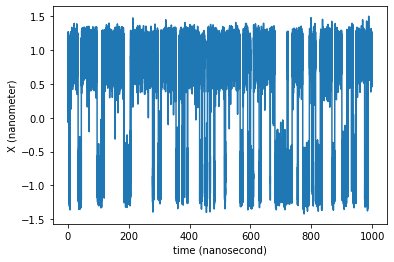

In [16]:
plt.plot(time.in_units_of(unit.nanoseconds), traj[:,0,0])
plt.xlabel('time ({})'.format(unit.nanoseconds))
plt.ylabel('X ({})'.format(position.unit))
plt.show()

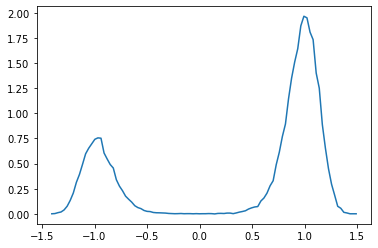

In [17]:
hist, bin_edges = np.histogram(traj[:,0,0],bins=100, density=True)
plt.plot((bin_edges[1:]+bin_edges[:-1])/2.0,hist)
plt.show()

## Discretizing the conformational space

We will consider in this notebook, for the shake of simplicity, that the coordinate space is unidimensional. Thus, the position of the particle is precised by only a float number, its X coordinate. Since we can not work in a continuos space, lets then start defining segments of the conformational space as conformational microstates. At this point the number of microstates or their size will not be a matter of discussion. Lets discretice the interval $[-2.0, 2.0)$ of the X coordinate in 40 bins (with a width of $\Delta x = 0.1 nm$, and lets label each bin with an integer number between 0 and 39 such as the bin $i$ will correspond to the segment $[-2.0+i\Delta x, -2.0+(i+1)\Delta x)$:

In [18]:
lower_limit = -2.0 * unit.nanometers
upper_limit = 2.0 * unit.nanometers
n_bins = 40
delta_x = (upper_limit-lower_limit)/n_bins

In [19]:
delta_x

Quantity(value=0.1, unit=nanometer)

In [20]:
n_frames = traj.shape[0]
discrete_traj = np.zeros([n_frames], dtype=int)

for frame_index in range(n_frames):
    bin_index = int(np.floor_divide((position[frame_index,0,0]-lower_limit)._value, delta_x._value))
    discrete_traj[frame_index]=bin_index

In [21]:
discrete_traj

array([29, 32, 30, ..., 10, 12,  8])

When coding, there is always more than a way to solve a problem. Check that we could had descretized the trajectory also this other two ways:

In [22]:
discrete_traj = np.floor_divide((position[:,0,0]-lower_limit)._value, delta_x._value).astype(int)

In [23]:
discrete_traj

array([29, 32, 30, ..., 10, 12,  8])

In [24]:
bin_edges = np.linspace(lower_limit._value, upper_limit._value, n_bins+1, True)
discrete_traj = np.digitize(position[:,0,0]._value, bin_edges, )-1

In [25]:
discrete_traj

array([30, 32, 30, ..., 10, 12,  8])

We already have the trajectory discretized. Each microstate was then labeled with an integer number, thats why the new discretized trajectory looks like an integer array.

## Number of visits or weight of a micro-state

Lets call "weight of a microstate" as the number of times the trajectory visited a certain microstate. Lets collect from the trajectory these weights:

In [27]:
w=np.zeros([n_bins], dtype=int)

for bin_index in discrete_traj:
    w[bin_index]+=1

In [28]:
w

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
np.sum(w>0)

30

Notice that this could have been solved using numpy or scipy methods as:

In [30]:
w = np.bincount(discrete_traj, minlength=n_bins)

In [31]:
w

array([0, 0, 0, ..., 0, 0, 0])

Or

In [32]:
w, _ = np.histogram(position[:,0,0], bins=bin_edges)

In [33]:
w

array([0, 0, 0, ..., 0, 0, 0])

In any case, the sum of the weights of all microstates is equal to the number of trajectory frames:

In [34]:
np.sum(w)

50000

In [35]:
n_frames

50000

Plotting the weight of each microstate is straightforward:

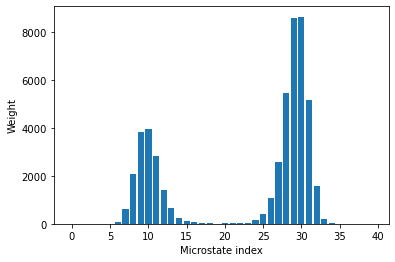

In [36]:
plt.bar(range(n_bins), w)
plt.ylabel('Weight')
plt.xlabel('Microstate index')
plt.show()

Using the bins edges we can plot the weights over the coordinate X. This time, instead of drawing steps or bars, lets place the value of the weight in the middle point of each bin:

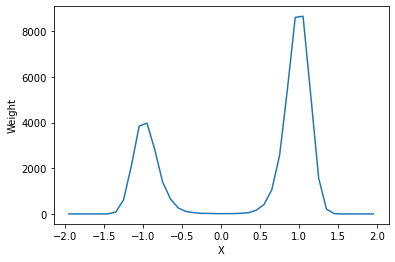

In [37]:
bins_mid_point = (bin_edges[1:]+bin_edges[:-1])/2.0
plt.plot(bins_mid_point, w)
plt.ylabel('Weight')
plt.xlabel('X')
plt.show()

## Occupation probability of a microstate

The probability of being the system in a given microstate is obtained dividing its weight by the total number of frames, or the sum of all microstate weights:

In [38]:
p = w/w.sum()

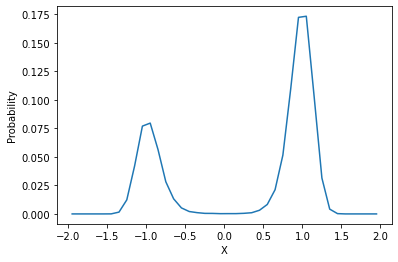

In [39]:
plt.plot(bins_mid_point, p)
plt.ylabel('Probability')
plt.xlabel('X')
plt.show()

Keep in mind that this former plot shows the occupation probability of each microstate, and not the probability density function of the system in the X coordinate. In other words, this is not the probability of being in any x coordinate, P(x), this is the probability of being in a segment of width $\Delta x$.

## Number of times a transition between microstates is observed along the trajectory or weight of a transition between microstates.

With the microstates defined, a matrix storing the times a transition between microstates is observed along the trajectory can be defined. Lets name this matrix $wt$. This way, the value $wt_{ij}$ is the number of times the system went from bin $i$ to bin $j$ in a timestep of length $\Delta t$. In this case $\Delta t = 20 ps$,  the same time interval between saved frames.

In [40]:
wt = np.zeros([n_bins, n_bins], dtype=int)

In [41]:
for frame_index in range(n_frames-1):
    bin_t = discrete_traj[frame_index]
    bin_tplus1 = discrete_traj[frame_index+1]
    wt[bin_t, bin_tplus1] += 1

In [42]:
wt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Cuantas transiciones fueron visitadas y cuantas no fueron visitadas?

In [44]:
n_bins * n_bins # número de transiciones posibles

1600

In [45]:
np.sum(wt==0) # número de transiciones no visitadas ni una sola vez

1220

In [46]:
np.sum(wt>0) # número de transiciones visitadas alguna vez

380

Veamos por ejemplo a donde hemos ido desde el bin 30 y cuantas veces:

In [47]:
wt[30,:]

array([0, 0, 0, ..., 0, 0, 0])

Podemos pintar el peso de las transiciones de 30 a cualquier bin $j$:

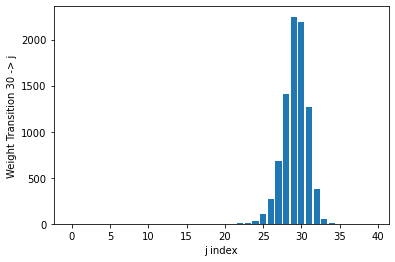

In [48]:
plt.bar(range(n_bins), wt[30,:])
plt.ylabel('Weight Transition 30 -> j')
plt.xlabel('j index')
plt.show()

O podemos recurrir a la coordenada del punto medio de cada bin destino para verlo sobre la dimensión espacial X

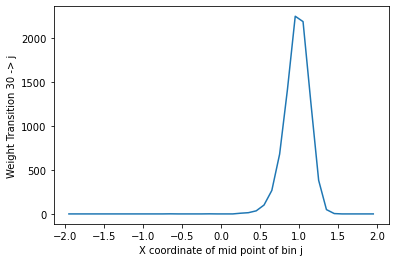

In [53]:
plt.plot(bins_mid_point, wt[30,:])
plt.ylabel('Weight Transition 30 -> j')
plt.xlabel('X coordinate of mid point of bin j')
plt.show()

Comprueba que la suma de los pesos de las transiciones de salida desde un microstado $i$ a cualquier $j$ es igual que la suma de los pesos de las transiciones de llegada al mismo $i$ desde cualquier $j$:

In [54]:
np.sum(wt[20,:])

13

In [55]:
np.sum(wt[:,20])

13